In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import math
import time
import scipy.stats as stats
from scipy.stats import zscore 

from collections import defaultdict
from scipy.stats.stats import pearsonr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot

CUSTOMER_SUPERMARKET = "../dataset/customer_supermarket.csv"
SALE_QTA_MERGE = "../dataset/customer_supermarket_sale_qta_merge.csv"
INCONSISTENT_PROD = '../dataset/inconsistent_ProdID_ProdDescr.json'
INCONSISTENT_COUNTRY = '../dataset/inconsistent_CustomerID_CustomerCountry.json'
FINAL_UNDERSTANDING = "../dataset/customer_supermarket_understanding.csv"

NO_INCONSISTENCY = "../dataset/customer_supermarket_no_inconsistency.csv"
INDICATORS = "../dataset/indicators.csv"
INDICATORS_NO_OUTLIER = "../dataset/indicators_no_outlier.csv"
NO_OUTLIER = "../dataset/customer_supermarket_no_outlier.csv"

## Loading the dataset

In [2]:
df = pd.read_csv(CUSTOMER_SUPERMARKET, sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")

## Attributes and check

In [3]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

In [4]:
df.isna().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

Here we can have an idea of data types we are going to use

| Attribute       | Type       |
|-----------------|------------|
| BasketID        | int64      |
| BasketDate      | datetime64 |
| Sale            | float64    |
| CustomerID      | int64      |
| CustomerCountry | object     |
| ProdID          | object     |
| ProdDescr       | object     |
| Qta             | int64      |

as we can see there are problems in the attribute values, so we have to evaluate what prevents us from getting the desired data types:

The execution df['BasketID'].astype(int) tell us that some rows contains literal inside the attribute BasketID, this means the data type cannot be converted to int

## Checking NaN values and duplicates

It is possible to evaluate the quality of the data from the point of view of the rows, based on two aspects:
- missing or partial value (NaN/Null values)
- duplicates
- duplicates products in the same basket

Any duplicates or rows with missing values are temporarily removed from the dataset to allow for better evaluation

In [5]:
# check if there are duplicates
areduplicates = df.duplicated().any()

# duplicates have been removed from the data set
df_nodup = df.drop_duplicates()

# check if there are missing or incomplete values
arenan = df.isnull().values.any()

# rows with missing or incomplete values have been removed from the data set
df_clean = df_nodup.dropna()

print("Duplicate rows in the dataset: ", areduplicates, "| Number or rows removed: ", len(df)-len(df_nodup))
print("NaN/Null values in the dataset: ", arenan, "| Number or rows removed: ", len(df_nodup)-len(df_clean))

df_Sale_Qta_merge = df_clean.groupby(['BasketID','BasketDate','ProdID']).agg({'Qta':np.sum,
                                                                         'Sale':np.sum,
                                                                         'CustomerID':'min',
                                                                         'CustomerCountry':'min',
                                                                         'ProdDescr':'min'}).reset_index()

df_Sale_Qta_merge.to_csv(SALE_QTA_MERGE, sep="\t", decimal=",", index=False)

print(f"Number of identical items in multiple rows of the same receipt {len(df_clean) - len(df_Sale_Qta_merge)}")

df = df_Sale_Qta_merge

Duplicate rows in the dataset:  True | Number or rows removed:  5232
NaN/Null values in the dataset:  True | Number or rows removed:  65073
Number of identical items in multiple rows of the same receipt 4918


## Checking data consistency

Here we are verifing that the dataset is consistent:

1. Every ProdID must match the same ProdDescr
2. Every CustomerID must match the same BasketID in the same BasketDate
3. Every CustomerID must match the same CustomerCountry

In [6]:
def inconsistent_set(K,V):
    
    inconsistentset = list()

    for key in tqdm(df[K].unique().tolist()):
        temp_df = df[df[K] == key]
        valueslist = temp_df[V].tolist()
        for value in valueslist:
            if(valueslist[0] != value):
                inconsistentset.append(key)
                break;
    return inconsistentset


# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

with open(INCONSISTENT_PROD, 'w') as f:
    json.dump(ProdID_ProdDescr_IS, f, sort_keys=True)


#2 True == no error
temp = df.groupby(['BasketID','BasketDate']).CustomerID.nunique().eq(1)
print("Every CustomerID matches the same BasketID in the same BasketDate: ", temp.all())

#to avoid graphical printing bug
time.sleep(0.1)
#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))


with open(INCONSISTENT_COUNTRY, 'w') as f:
    json.dump(CustomerID_CustomerCountry_IS, f, sort_keys=True)

100%|██████████| 3684/3684 [01:30<00:00, 40.61it/s]


Number of not consistent ProdDescr: 213
Every CustomerID matches the same BasketID in the same BasketDate:  True


100%|██████████| 4372/4372 [01:48<00:00, 40.27it/s]

Number of not consistent CustomerCountry: 8


## Converting attributes to correct data type

Here we are changing the type of attributes. This imply a little cleaning phase over BasketID because there are characters inside the values

In [7]:
#df = pd.read_csv(SALE_QTA_MERGE, sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")

df['CustomerID'] = pd.to_numeric(df.CustomerID)
df.CustomerID = df.CustomerID.astype(int)

## Statistics and data understanding

Here are informations about quantities

In [8]:
print("Number of clients: ",len(df['CustomerID'].unique()))
print("Number of products: ",len(df['ProdID'].unique()))
print("Number of purchase: ",len(df['BasketID'].unique()))
print("Distinct Customer Country: \t", len(df.CustomerCountry.unique()))

# number of items cancelled in the basket by every customer
basket_cancelled = df[df['BasketID'].str.contains("C")]
print("Number or rows with cancelled items: ", len(basket_cancelled))

#print("Distinct values in ProdID: \t", df_clean.ProdID.unique())
#print("Distinct values in ProdDescr: \t", df_clean.ProdDescr.unique())

Number of clients:  4372
Number of products:  3684
Number of purchase:  22190
Distinct Customer Country: 	 37
Number or rows with cancelled items:  8806


We have people coming from unspecified countries, a generic "European Community", EIRE which stands for Ireland and RSA which stands for Republic of South Africa.

In [9]:
print("Number of customers from Unspecified countries: \t", (df.CustomerCountry == "Unspecified").sum())
print("Number of customers from generic European Community countries: \t", (df.CustomerCountry == "European Community").sum())

Number of customers from Unspecified countries: 	 239
Number of customers from generic European Community countries: 	 61


In [10]:
df.describe()

,Qta,Sale,CustomerID
count,396687.000000,396687.000000,396687.000000
mean,12.334289,3.517171,15275.508817
std,251.837689,71.148484,1714.300274
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13923.000000
50%,6.000000,1.950000,15133.000000
75%,12.000000,3.750000,16779.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df.to_csv(FINAL_UNDERSTANDING, index=False)

## Data cleaning

The following cells will improve the DF, which presents inconsistency, missing values and outliers, thanks to consideration done during the data understanding phase

In [12]:
df = pd.read_csv(FINAL_UNDERSTANDING, parse_dates=["BasketDate"], decimal=",")
df.Sale = df.Sale.astype(float)

/home/zmlinux/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



For every canceled basket ('C'+'BasketID') check if exists at least one counterpart

In [13]:
df_check = df[(df['BasketID'].str.contains('C')) & (df['ProdID'] != 'D')][['CustomerID','Qta','ProdID']]
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Qta'] == -col[1]) & (df['ProdID'] == col[2])].shape[0] == 0: 
        print(True)
        break

True


Remove from the dataset the rows with canceled basket and possible counterpart (if there are more then one counterpart, the first will be deleted)

In [14]:
df_temp = df[(df['BasketID'].str.contains('C')) & (df['ProdID'] != 'D')]

rows_with_counterparts = []
rows_without_counterparts = []

for index, col in df_temp.iterrows():
    df_temp = df[(df['CustomerID'] == col['CustomerID']) & (df['Qta'] == -col['Qta']) & (df['ProdID'] == col['ProdID'])]
    
    if df_temp.shape[0] == 0: 
        rows_without_counterparts.append(index)
    else:
        rows_with_counterparts.append(index)
        rows_with_counterparts.append(df_temp.index[0])
    
rows_to_be_dropped = rows_with_counterparts + rows_without_counterparts

df_canceled_basket = df.drop(df.index[rows_to_be_dropped])

print("Total number of dropped rows: ", len(df)-len(df_canceled_basket))

df = df_canceled_basket

Total number of dropped rows:  11775


In [15]:
# inconsistency resolution

def inconsistency_resolver(path,col1,col2):
    
    with open(path, 'r') as f:
        inconsistent_list = json.load(f)
        
    df_inconsistent = df[df[col1].isin(inconsistent_list)]

    df_grouped = df_inconsistent.groupby([col1,col2]).size().reset_index()
    
    df_grouped = df_grouped.sort_values(0, ascending=False).drop_duplicates(col1).sort_index()
    
    mydict = pd.Series(df_grouped[col2].values,index=df_grouped[col1]).to_dict()
    
    for k,v in mydict.items():
        
        df.loc[df[col1] == k, col2] = v

inconsistency_resolver(INCONSISTENT_COUNTRY,"CustomerID","CustomerCountry") 
inconsistency_resolver(INCONSISTENT_PROD,"ProdID","ProdDescr") 

In [16]:
''' check if inconsistency has been solved
# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))
'''

' check if inconsistency has been solved\n# 1\nProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")\n            \nprint("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))\n\n#3 \nCustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")\n            \nprint("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))\n'

DF without inconsistency serialization

In [17]:
df.to_csv(NO_INCONSISTENCY, sep="\t", decimal=",", index=False)

## Indicators

In [79]:
df = pd.read_csv(NO_INCONSISTENCY, sep="\t", parse_dates=["BasketDate"], decimal=",")
print(df.head())
print(df.info())

  BasketID          BasketDate  ProdID  Qta  Sale  CustomerID CustomerCountry  \
0   536365 2010-01-12 08:26:00   21730    6  4.25       17850  United Kingdom   
1   536365 2010-01-12 08:26:00   22752    2  7.65       17850  United Kingdom   
2   536365 2010-01-12 08:26:00   71053    6  3.39       17850  United Kingdom   
3   536365 2010-01-12 08:26:00  84029E    6  3.39       17850  United Kingdom   
4   536365 2010-01-12 08:26:00  84029G    6  3.39       17850  United Kingdom   

                             ProdDescr  
0    GLASS STAR FROSTED T-LIGHT HOLDER  
1         SET 7 BABUSHKA NESTING BOXES  
2                  WHITE METAL LANTERN  
3       RED WOOLLY HOTTIE WHITE HEART.  
4  KNITTED UNION FLAG HOT WATER BOTTLE  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384912 entries, 0 to 384911
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         384912 non-null  object    

/home/zmlinux/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



# I - indicator
the total number of items purchased by a customer during the period of
observation.

In [80]:
df_i = df.groupby("CustomerID").sum().reset_index()
df_i = df_i[["CustomerID", "Qta"]]
df_i

,CustomerID,Qta
0,12347,2458
1,12348,2341
2,12349,631
3,12350,197
4,12352,473
...,...,...
4321,18280,45
4322,18281,54
4323,18282,103
4324,18283,1357


# Iu - indicator
the number of distinct items bought by a customer in the period of
observation.

In [81]:
df_iu = df.groupby('CustomerID')['ProdID'].nunique().reset_index()
df_iu

,CustomerID,ProdID
0,12347,103
1,12348,22
2,12349,73
3,12350,17
4,12352,59
...,...,...
4321,18280,10
4322,18281,7
4323,18282,12
4324,18283,263


# Imax - indicator
the maximum number of items purchased by a customer during a
shopping session

In [82]:
df_imax = df.groupby(["CustomerID", "BasketID"]).Qta.sum()
df_imax = df_imax.groupby(level=0).head(1).reset_index()

#df_imax = df_imax.max(level=0)

df_imax

,CustomerID,BasketID,Qta
0,12347,537626,319
1,12348,539318,1254
2,12349,577609,631
3,12350,543037,197
4,12352,544156,98
...,...,...,...
4321,18280,545712,45
4322,18281,556464,54
4323,18282,562525,75
4324,18283,540350,61


# E - indicator
the Shannon entropy on the purchasing behaviour of the customer

In [83]:
# Entropy helper function 
import numpy as np
from scipy.stats import entropy
from math import log, e
import pandas as pd   

""" Usage: pandas_entropy(df['column1']) """

def pandas_entropy(column, base=None):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

In [84]:
df_temp = df.groupby(["CustomerID", "BasketID"]).Qta.sum().reset_index()
df_entropy = pd.DataFrame(df.CustomerID.unique(), columns=["CustomerID"])

entropies = []

for customer in df_temp.CustomerID.unique():
    customer_baskets = df_temp[df_temp.CustomerID == customer]
    entropies.append(pandas_entropy(customer_baskets["Qta"]))
    #print(df_temp[df_temp.CustomerID == customer])
    
df_entropy["Entropy"] = entropies

# Additional indicators

### Total Spending
We compute the total amount spent by each customer in the observation period

In [85]:
df_tot = df.groupby(["CustomerID"]).Sale.sum()
df_tot = df_tot.groupby(level=0).head(1).reset_index()

print(df_tot)

      CustomerID     Sale
0          12347   481.21
1          12348   178.71
2          12349   605.10
3          12350    65.30
4          12352  1337.42
...          ...      ...
4321       18280    47.65
4322       18281    39.36
4323       18282    62.39
4324       18283  1174.33
4325       18287   104.55

[4326 rows x 2 columns]


### Average spending
We compute the average basket value for each user

In [86]:
df_customer_basket_groupby_sum = df.groupby(["CustomerID",'BasketID'], as_index=False).agg({"Sale":sum})
df_mean = df_customer_basket_groupby_sum.groupby('CustomerID')['Sale'].mean()
df_mean = df_mean.groupby(level=0).head(1).reset_index()

print(df_mean)

      CustomerID        Sale
0          12347   68.744286
1          12348   44.677500
2          12349  605.100000
3          12350   65.300000
4          12352  167.177500
...          ...         ...
4321       18280   47.650000
4322       18281   39.360000
4323       18282   31.195000
4324       18283   73.395625
4325       18287   34.850000

[4326 rows x 2 columns]


### Discounts per user
We count the number of times a customer used a discount

In [87]:
df_discounts = df[df['ProdDescr'] == "Discount"]['CustomerID'].value_counts()
len(df_discounts)

24

### Number of baskets per user

In [88]:
df_num_baskets = df.groupby('CustomerID')['BasketID'].nunique().reset_index()
df_num_baskets

,CustomerID,BasketID
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,8
...,...,...
4321,18280,1
4322,18281,1
4323,18282,2
4324,18283,16


### Putting together all indicators

In [89]:
print(df_tot.Sale)

0        481.21
1        178.71
2        605.10
3         65.30
4       1337.42
         ...   
4321      47.65
4322      39.36
4323      62.39
4324    1174.33
4325     104.55
Name: Sale, Length: 4326, dtype: float64


In [90]:
df_indicators = pd.DataFrame(df.CustomerID.unique(), columns=["CustomerID"]).sort_values(by=['CustomerID'])
df_indicators["Entropy"] = df_entropy.Entropy.values
df_indicators["i"] = df_i.Qta.values
df_indicators["iu"] = df_iu.ProdID.values
df_indicators["imax"] = df_imax.Qta.values
df_indicators["tot_sales"] = df_tot.Sale.values
df_indicators["mean_sales"] = df_mean.Sale.values
df_indicators["num_baskets"] = df_num_baskets.BasketID.values

df_indicators.to_csv(INDICATORS, index=False)
print(df_indicators)

      CustomerID   Entropy     i   iu  imax  tot_sales  mean_sales  \
409        12347  1.945910  2458  103   319     481.21   68.744286   
810        12348  1.386294  2341   22  1254     178.71   44.677500   
4191       12349 -0.000000   631   73   631     605.10  605.100000   
1349       12350 -0.000000   197   17   197      65.30   65.300000   
1499       12352  2.079442   473   59    98    1337.42  167.177500   
...          ...       ...   ...  ...   ...        ...         ...   
1768       18280 -0.000000    45   10    45      47.65   47.650000   
2805       18281 -0.000000    54    7    54      39.36   39.360000   
3181       18282  0.693147   103   12    75      62.39   31.195000   
919        18283  2.566599  1357  263    61    1174.33   73.395625   
2635       18287  1.098612  1586   59   488     104.55   34.850000   

      num_baskets  
409             7  
810             4  
4191            1  
1349            1  
1499            8  
...           ...  
1768            1  

## Indicators box plots

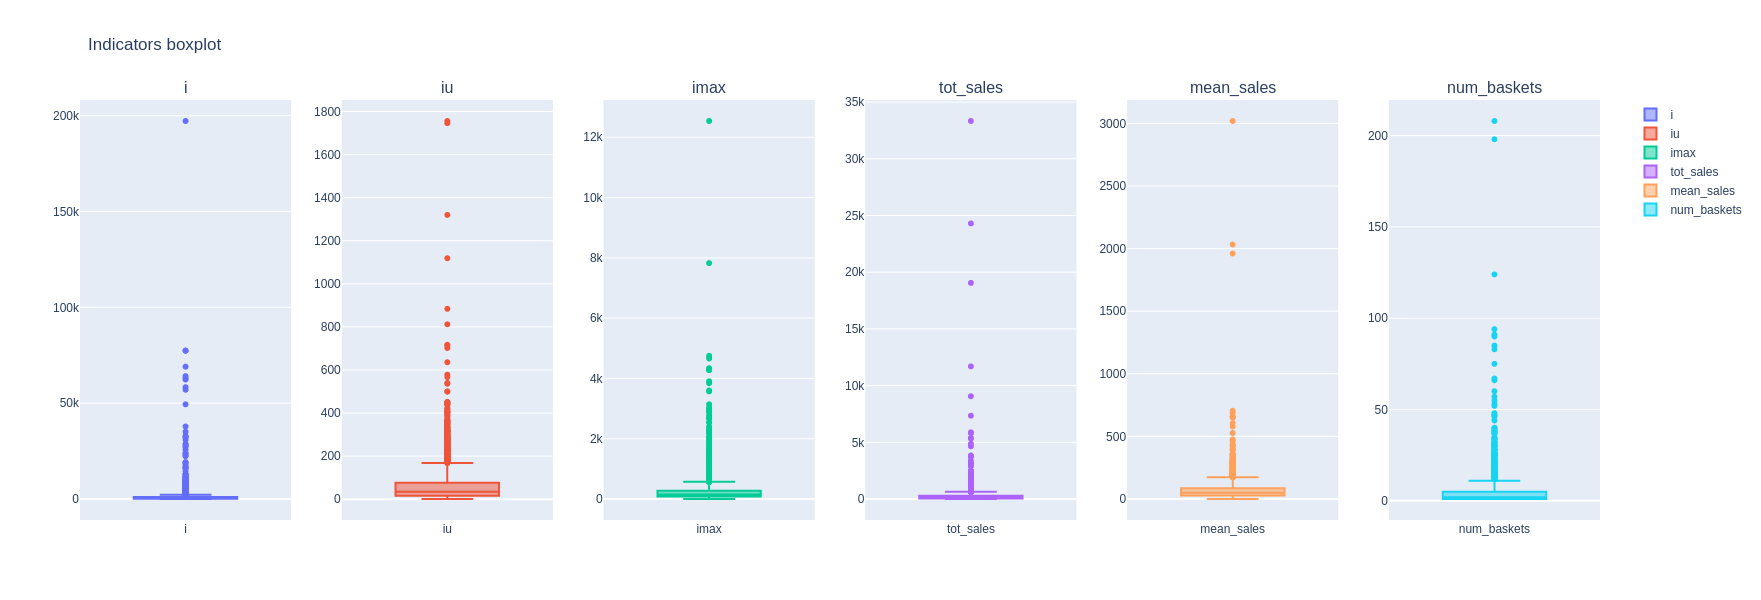

In [91]:
def boxplots(dataframe):
    fig = make_subplots(
        rows=1, cols=6,
        subplot_titles=("i", "iu", "imax", "tot_sales", "mean_sales", "num_baskets")
    )

    fig.add_trace(
        go.Box(y=dataframe['i'],name="i"),
        row=1,col=1
    )
    fig.add_trace(
        go.Box(y=dataframe['iu'],name="iu"),
        row=1,col=2
    )
    fig.add_trace(
        go.Box(y=dataframe['imax'],name="imax"),
        row=1,col=3
    )
    fig.add_trace(
        go.Box(y=dataframe['tot_sales'],name="tot_sales"),
        row=1,col=4
    )
    fig.add_trace(
        go.Box(y=dataframe['mean_sales'],name="mean_sales"),
        row=1,col=5
    )
    fig.add_trace(
        go.Box(y=dataframe['num_baskets'],name="num_baskets"),
        row=1,col=6
    )

    fig.update_layout(height=600,title="Indicators boxplot")
    fig.show()
    
boxplots(df_indicators)

## Outlier removal

In [92]:
z_scores = stats.zscore(df_indicators)

abs_z_scores = np.abs(z_scores)

filtered_entries = (abs_z_scores < 3).all(axis=1)

df_indicators_no_outlier = df_indicators[filtered_entries]

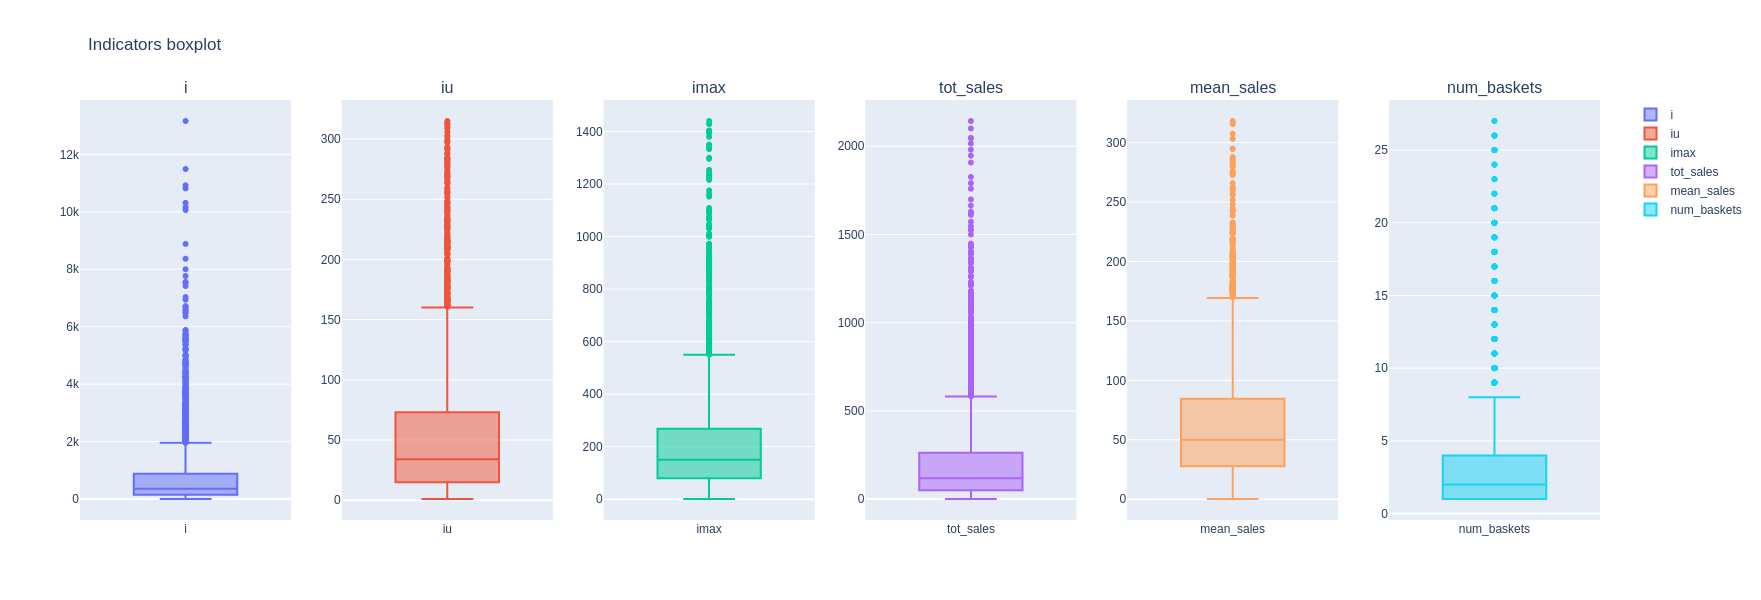

In [93]:
boxplots(df_indicators_no_outlier)

### Serializing indicators without outliers and DF without outliers

In [94]:
df_indicators_no_outlier.to_csv(INDICATORS_NO_OUTLIER, index=False)

df_no_outlier = df.loc[df['CustomerID'].isin(df_indicators_no_outlier['CustomerID'].unique().tolist())]
df_no_outlier.to_csv(NO_OUTLIER, index=False)

## Distributions

### Grid of plots

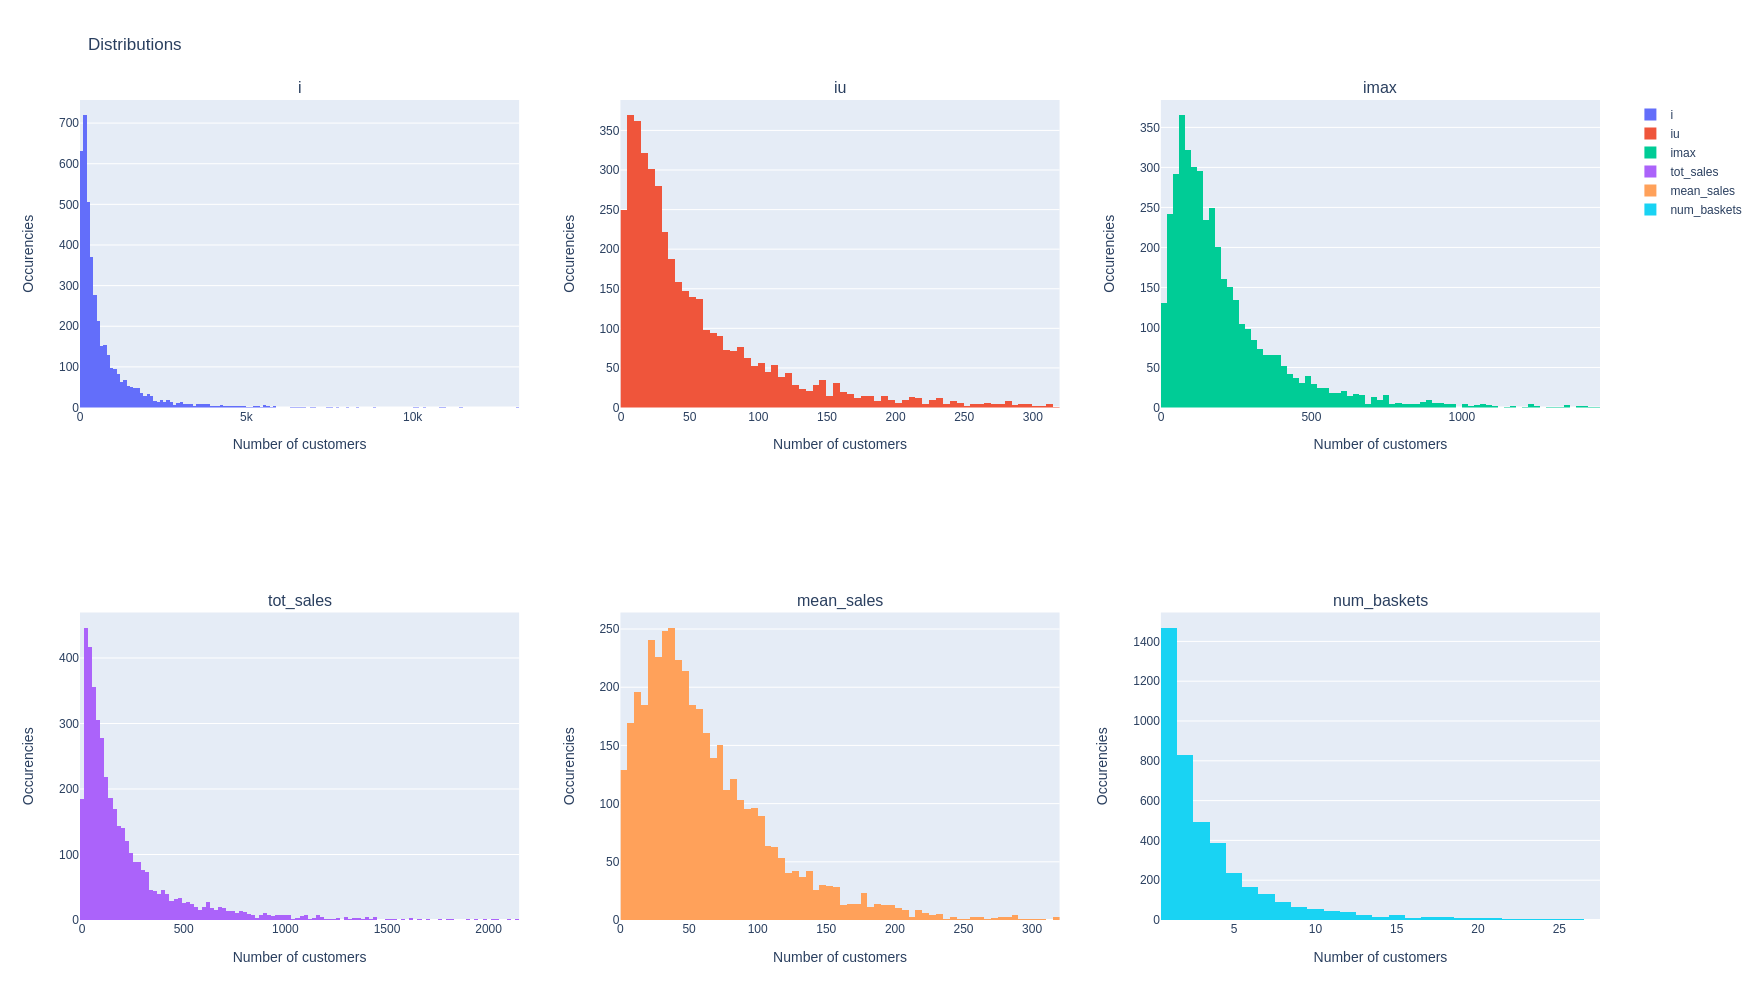

In [95]:
#df = px.data.tips()

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=("i","iu","imax","tot_sales","mean_sales","num_baskets")
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['i'].tolist(),name="i"),
    row=1, col=1
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['iu'].tolist(),name="iu"),
    row=1, col=2
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['imax'].tolist(),name="imax"),
    row=1, col=3
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['tot_sales'].tolist(),name="tot_sales"),
    row=2, col=1
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['mean_sales'].tolist(),name="mean_sales"),
    row=2, col=2
)


# amount spent by customer distribution 
fig.add_trace(
    go.Histogram(x=df_indicators_no_outlier['num_baskets'].tolist(),name="num_baskets"),
    row=2, col=3
)

fig.update_xaxes(title_text = "Number of customers")
fig.update_yaxes(title_text = "Occurencies")
fig.update_layout(height=1000, width=1200, title_text="Distributions")
#fig.write_image("../output/task1/indicators_distributions.png")
fig.show()

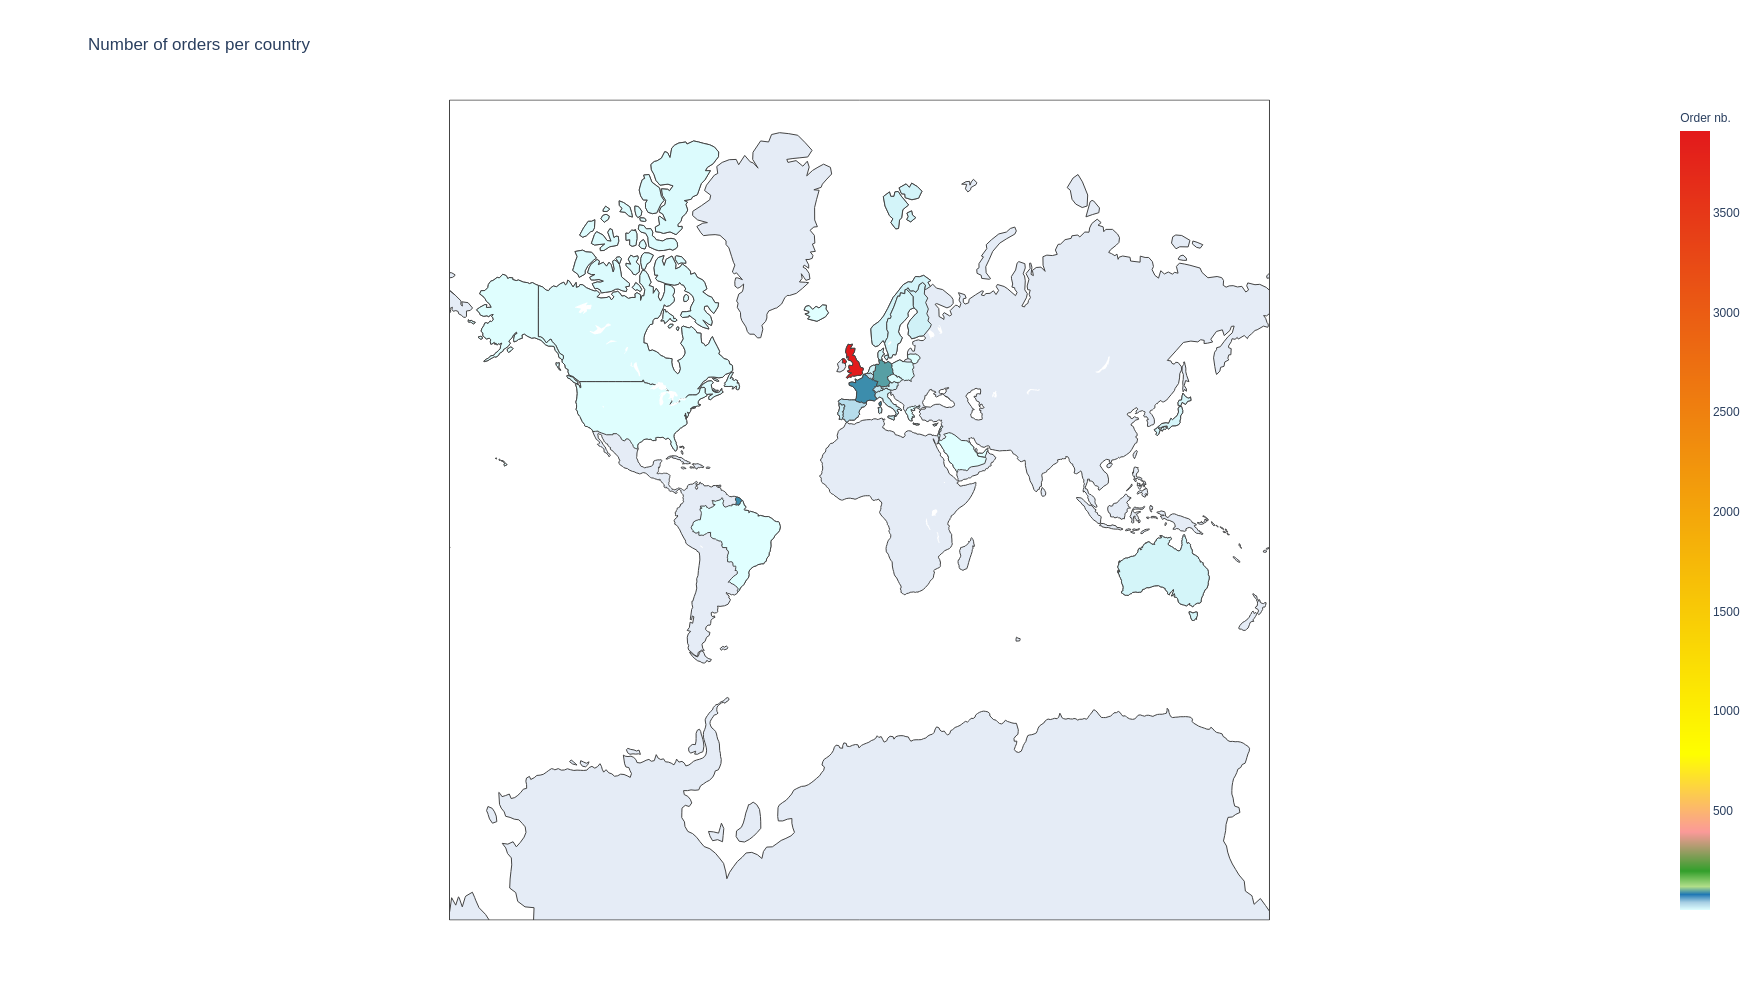

In [96]:
temp = df[['CustomerID', 'CustomerCountry']].groupby(['CustomerID', 'CustomerCountry']).count()
temp = temp.reset_index(drop = False)
countries = temp['CustomerCountry'].value_counts()
data = dict(type='choropleth',
    locations = countries.index,
    locationmode = 'country names', z = countries,
    text = countries.index, colorbar = {'title':'Order nb.'},
    colorscale=[[0, 'rgb(224,255,255)'],
                [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
                [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
                [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
                [1, 'rgb(227,26,28)']],    
    reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',height=1000, width=1200,
    geo = dict(showframe = True, projection={'type':'mercator'})
            )
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### Amount of qta per month and sum of income per month during the observation date

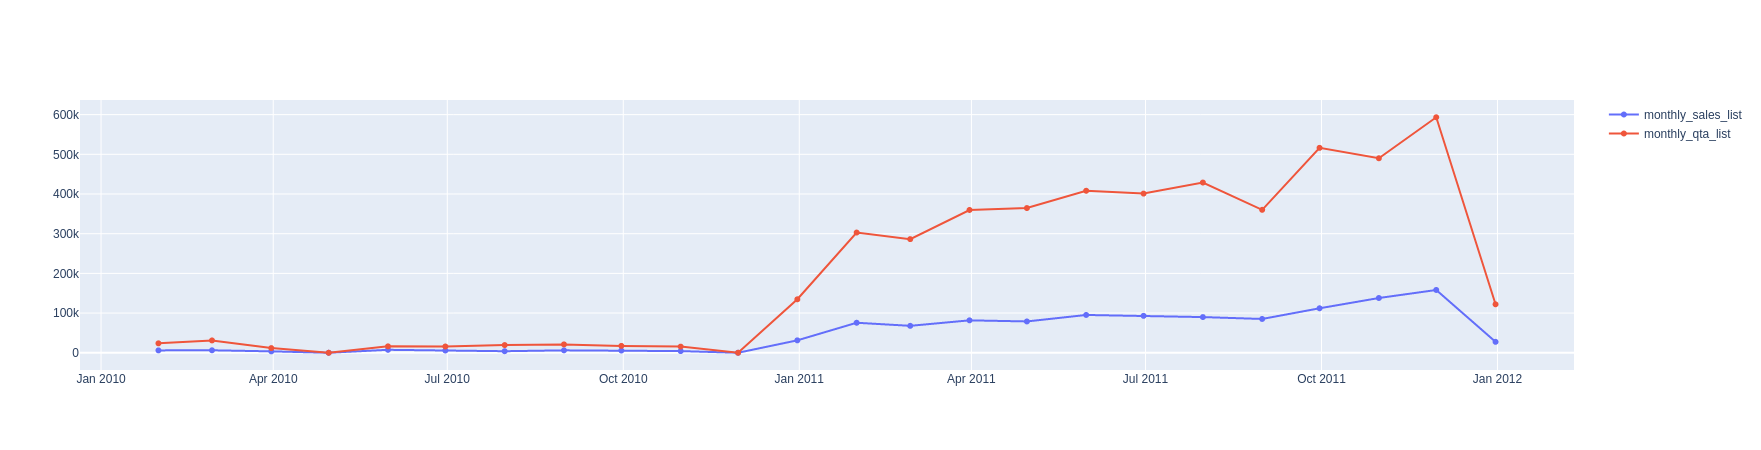

In [97]:
df_temp = df.set_index("BasketDate").copy()
monthly_qta = df_temp.groupby(pd.Grouper(freq='M'))["Qta"].sum()
monthly_sales = df_temp.groupby(pd.Grouper(freq='M'))["Sale"].sum()

#print(monthly_sales)
'''
print(monthly_receipt)
print(monthly_qta)
print(monthly_sales)

plt.figure(figsize=(16,5))
plt.plot(monthly_receipt.index, monthly_qta, color='tab:blue', marker="o")
plt.plot(monthly_qta.index, monthly_qta, color='tab:red', marker="x")
plt.plot(monthly_sales.index, monthly_sales, color='tab:green', marker="*")
'''
month_list = monthly_qta.keys().to_list()
monthly_qta_list = monthly_qta.to_list()
monthly_sales_list = monthly_sales.to_list()

fig = go.Figure()

fig.add_trace(go.Scatter(x=month_list, y=monthly_sales_list,
                    mode='lines+markers',
                    name='monthly_sales_list'))

fig.add_trace(go.Scatter(x=month_list, y=monthly_qta_list,
                    mode='lines+markers',
                    name='monthly_qta_list'))


fig.show()

### Sales per country

In [98]:
df_sales_per_country = df.groupby(["CustomerCountry"])["Sale"].sum().reset_index()
print(df_sales_per_country)

         CustomerCountry          Sale
0              Australia  3.091180e+03
1                Austria  1.693900e+03
2                Bahrain  7.895000e+01
3                Belgium  7.305500e+03
4                 Brazil  1.426000e+02
5                 Canada  9.105800e+02
6        Channel Islands  3.095000e+03
7                 Cyprus  3.124560e+03
8         Czech Republic  3.678000e+01
9                Denmark  1.165230e+03
10                  EIRE  3.025949e+04
11    European Community  2.898000e+02
12               Finland  3.508440e+03
13                France  3.526396e+04
14               Germany  3.171144e+04
15                Greece  6.632900e+02
16               Iceland  4.812100e+02
17                Israel  8.985900e+02
18                 Italy  3.463190e+03
19                 Japan  6.546600e+02
20               Lebanon  2.424400e+02
21             Lithuania  9.944000e+01
22                 Malta  5.352400e+02
23           Netherlands  6.433930e+03
24                Norway 

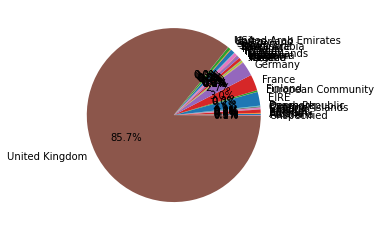

In [99]:
# the pie plot is horrible because of england, that probably has some outliers
#explode=np.zeros(len(df_sales_per_country.CustomerCountry))

plt.pie(df_sales_per_country.Sale, labels=df_sales_per_country.CustomerCountry, autopct='%1.1f%%')
plt.savefig('../output/task1/salespercountry.png')
plt.show()

### Most bought items

In [100]:
cols_dropped = [2, 3, 6]
df_most_bought = df.groupby(["ProdID", "ProdDescr"]).sum().reset_index()
#df_most_bought = df_most_bought.drop(df_most_bought.columns[cols_dropped], axis=1)
df_most_bought = df_most_bought.sort_values(by="Qta", ascending=False)
#df_most_bought = df_most_bought.groupby(level=0).head(1).reset_index()
df_most_bought 

#print(df[df.ProdDescr == "Discount"])

,ProdID,ProdDescr,Qta,Sale,CustomerID
2799,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54079,136.95,7154381
1086,22197,POPCORN HOLDER,48935,886.29,15918276
3213,85099B,JUMBO BAG RED RETROSPOT,45195,3231.49,24271749
3053,84879,ASSORTED COLOUR BIRD ORNAMENT,35234,2339.52,20888753
3227,85123A,WHITE HANGING HEART T-LIGHT HOLDER,34239,5817.47,30570719
...,...,...,...,...,...
3433,90071,RUBY GLASS CLUSTER EARRINGS,1,1.25,14801
2582,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,7.95,14083
256,20901,VINTAGE KEEPSAKE BOX PINK FLOWER,1,6.35,15058
2501,37461,FUNKY MONKEY MUG,1,1.25,14606


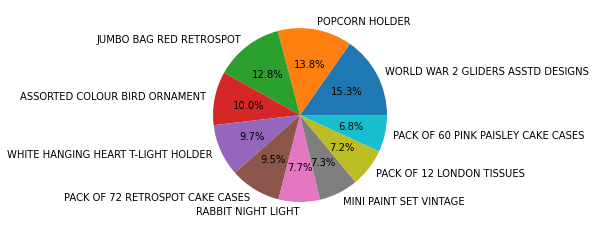

In [101]:
plt.pie(df_most_bought[:10].Qta, labels=df_most_bought[:10].ProdDescr, autopct='%1.1f%%')
plt.savefig("../output/task1/most_bought_item_piechart.png")
plt.show()

### Most bought item per country


In [102]:
#cols_dropped = [3, 4, 7]
df_mb_country = df.groupby(["ProdID", "ProdDescr", "CustomerCountry"]).sum().reset_index()
df_mb_country = df_mb_country.drop(["Sale"], axis = 1)

df_mb_country = df_mb_country[df_mb_country.groupby(["CustomerCountry"])["Qta"].transform("max") == df_mb_country["Qta"]].reset_index()

#df_mb_country = df_mb_country.groupby(["CustomerCountry"]).agg({"Qta" : "max"}).reset_index()
#print(df_mb_country.CustomerCountry.unique())


print(df_mb_country)


    index  ProdID                            ProdDescr       CustomerCountry  \
0     135   16008  SMALL FOLDING SCISSOR(POINTED EDGE)                Norway   
1     659   20719               WOODLAND CHARLOTTE BAG                Israel   
2    1960   21212      PACK OF 72 RETROSPOT CAKE CASES               Belgium   
3    2092   21232       STRAWBERRY CERAMIC TRINKET BOX                Poland   
4    2668   21430   SET/3 RED GINGHAM ROSE STORAGE BOX                Brazil   
..    ...     ...                                  ...                   ...   
57  17372   84929   ASSTD FRUIT+FLOWERS FRIDGE MAGNETS               Lebanon   
58  17475  84971S            SMALL HEART FLOWERS HOOK                 Brazil   
59  17619  84997D      CHILDRENS CUTLERY POLKADOT PINK               Finland   
60  17629  84997D      CHILDRENS CUTLERY POLKADOT PINK                 Spain   
61  18265   85215       ASSORTED CHEESE FRIDGE MAGNETS  United Arab Emirates   

     Qta  CustomerID  
0    576       4

## Correlation

In [103]:
df = pd.read_csv(INDICATORS_NO_OUTLIER).drop("CustomerID", axis=1)

### Correlation matrix

There seems to be absolutely no correlation between the values of the dataset

In [104]:
correlations = df.corr(method="pearson")
correlations

,Entropy,i,iu,imax,tot_sales,mean_sales,num_baskets
Entropy,1.000000,0.661838,0.644350,0.070415,0.693028,-0.032444,0.883359
i,0.661838,1.000000,0.564779,0.421030,0.594464,0.043214,0.738654
iu,0.644350,0.564779,1.000000,0.232622,0.875552,0.492826,0.602460
imax,0.070415,0.421030,0.232622,1.000000,0.145184,0.215092,0.060029
tot_sales,0.693028,0.594464,0.875552,0.145184,1.000000,0.450941,0.725880
mean_sales,-0.032444,0.043214,0.492826,0.215092,0.450941,1.000000,-0.057467
num_baskets,0.883359,0.738654,0.602460,0.060029,0.725880,-0.057467,1.000000


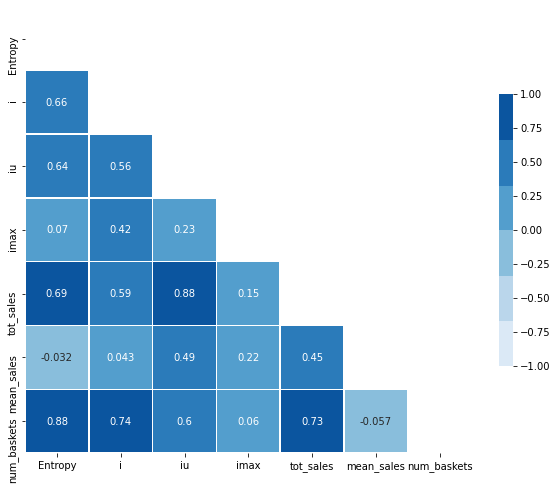

In [105]:
import seaborn as sns

mask = np.triu(np.ones_like(correlations, dtype=bool))

# this diverging palette is pretty dull since everything is unrelated
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.color_palette("Blues")
sns_heat = sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})

sns_heat.figure.savefig('../output/task1/correlationmatrix.png')

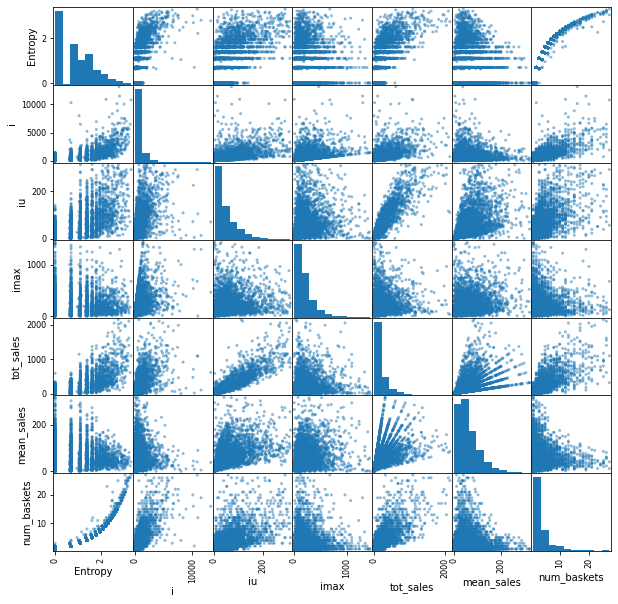

In [106]:
pd.plotting.scatter_matrix(df,figsize=(10,10))
plt.savefig('../output/task1/scattermatrix.png')
plt.show()